This notebook uses __code6__ in conjunction with nonlinear optimization routines provided by [Mystic](https://github.com/uqfoundation/mystic) to estimate the pixel aperture size, and thus fill factor, of the Fujifilm G50s camera.  It does so first by retrieving a model for the lens from data from [Olaf Optical Testing](https://www.olafoptical.com/), then locking in this model and optimizing for the pixel aperture to match the system MTF at frequencies up to nyquist.

Fitting is not done above nyquist due to aliasing.  This will be seen in the error between the model and measurement, shown below.

The image analyzed was provided by [Jim Kasson](https://blog.kasson.com/), and the MTF computed with [MTF Mapper](https://sourceforge.net/p/mtfmapper/home/Home/), a FOSS slanted-edge MTF tool.  A minimal parser is provided alongside a "verbose" output file from MTF Mapper, containg the measured MTF data.

In [1]:
import os
import sys
sys.path.append('Estimating Effective Pixel Aperture_files')
sys.path.append('..')

import numpy as np
from scipy.interpolate import UnivariateSpline

import matplotlib as mpl
from matplotlib import pyplot as plt
% matplotlib inline
inline = inline_rc = dict(mpl.rcParams)
plt.style.use('ggplot')

from code6 import FringeZernike, PSF, MTF, PixelAperture

from MTFMapperParser import parse_mtfmapper_sfr_data

from mystic.solvers import fmin_powell

In [1]:
# uses dcraw to turn out dng into a tiff
#!"../lib/dcraw/dcraw.exe"  -d -T -4 "../fujifiles/_GF02247.dng"

In [92]:
# intermediate step is a crop in photoshop, could use PIL too.  Then use MTF mapper to extract the red bayer channel MTF
#!"../lib/mtf_mapper.exe" "../fujifiles/_GF02247_crop3.tif" "../resfuji" --single-roi --bayer red -q -t 0.3

16-bit input image, no upconversion required
Thresholding image ...
Computing gradients ...
Component labelling ...
    Quantiles ->                       5%    25%    50%    75%    95%
Statistics on all edges:           0.4848 0.4848 0.4848 0.4848 0.4848  (total=1)


In [2]:
# grab the data and convert units of cy/px to cy/mm
gfx_pp = 5.3052
raw = parse_mtfmapper_sfr_data(r'Estimating Effective Pixel Aperture_files/edge_sfr_values_r.txt', gfx_pp)

# get the unit axis, which is at the top level of the dictionary from the parser
unit = raw['mtf_unit']
green = 0.55
blue = 0.440
red = 0.630

In [3]:
# specify a target location in px for the edge, iterate through the data to find it and pull the data, 
# which I loosely refer to as tan/sag.  The true azimuth is a bit off from tan/sag due to the slant of the edge.
target = (150, 150)

# pull selected data from the measurements
output_tan = None
output_sag = None
last_distance = 1e99
distances = []
for dataset in raw['data']:
    x,y = dataset['pixel_x'], dataset['pixel_y']
    dist = np.sqrt((x-target[0])**2 + (y-target[1])**2)
    distances.append(dist)
    if dist < last_distance:
        output_tan = dataset['mtf_tan']
        output_sag = dataset['mtf_sag']
    last_distance = dist

# interpolate the gathered MTF to nice numbers
sys_freqs = list(range(10, 100, 10))
interpf = UnivariateSpline(unit, output_tan)
sys_mtf = np.asarray(interpf(sys_freqs))

In [4]:
# define truth, from MTF measurements
freqs = np.asarray([40, 80, 120, 160, 200])
truths = np.asarray([0.85, 0.713, 0.585, 0.481, 0.355])
efl = 85 # the EFL is not truly 85, but it just causes a small scale error and will couple 
# exactly into our f/# estimate when we look in the MTF domain.

# use nonlinear optimization to build a model of the lens
def constraints(optimization_params):
    sa3, sa5, defocus, fno = optimization_params
    out = []
    if sa3 > 20:
        sa3 = 20
    if sa3 < -20:
        sa3 = -20
    
    if sa5 > 0.25*sa3:
        sa5 = 0.25*sa3
    if sa5 < -0.25*sa3:
        sa5 = -0.25*sa3
    
    if defocus > 10:
        defocus = 10
    if defocus < -10:
        defocus = -10
    
    if fno < 3.8:
        fno = 3.8
    if fno > 4.5:
        fno = 4.5
    
    return [sa3, sa5, defocus, fno]

def opt_fcn(optimization_params):
    # extract optimization parameters
    sa3, sa5, defocus, fno = optimization_params
    
    # generate a model for our parameters and fit it to truth
    pupil = FringeZernike(Z3=defocus, Z8=sa3, Z15=sa5, epd=efl/fno, wavelength=red, opd_unit='nm', rms_norm=True)
    sim_mtf = MTF.from_pupil(pupil, efl)
    sim_vals = sim_mtf.exact_polar(freqs)
    
    return (np.square(truths-sim_vals)).sum()

In [6]:
lens_params = fmin_powell(opt_fcn, [12.5, -2.5, 0, 4], constraints=constraints, retall=1)

Optimization terminated successfully.
         Current function value: 0.000128
         Iterations: 11
         Function evaluations: 653


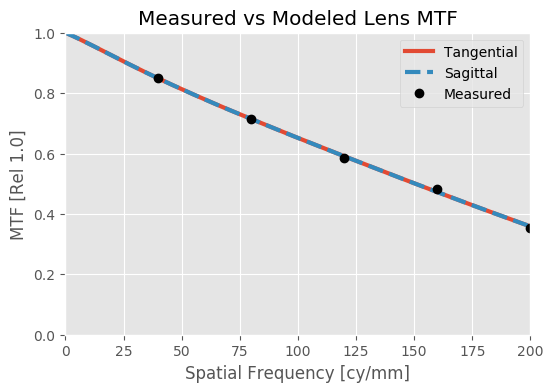

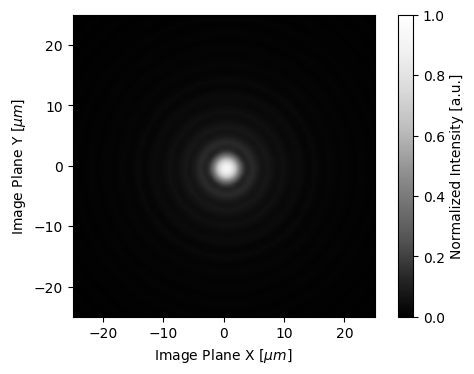

In [7]:
sa3, sa5, defocus, fno = lens_params[0]
lens_pupil = FringeZernike(Z3=defocus, Z8=sa3, Z15=sa5, epd=efl/fno, wavelength=red, opd_unit='nm', rms_norm=True)
lens_psf = PSF.from_pupil(lens_pupil, efl)
lens_mtf = MTF.from_psf(lens_psf)
lens_mtf.plot_tan_sag(max_freq=200)
plt.gca().plot(freqs, truths, 'ko', label='Measured')
plt.legend()
plt.gca().set(title='Measured vs Modeled Lens MTF')
plt.savefig('Estimating Effective Pixel Aperture_files/lens_mtf_meas_vs_model.png', dpi=300, bbox_inches='tight')

mpl.rcParams.update(inline)
lens_psf.plot2d()
plt.savefig('Estimating Effective Pixel Aperture_files/lens_psf.png', dpi=300, bbox_inches='tight')
plt.style.use('ggplot')

In [8]:
def opt_fcn_sys(opt_params):
    pixel_size = opt_params
    pix = PixelAperture(pixel_size, samples=1000, sample_spacing=0.05)
    sys_psf = lens_psf.conv(pix)
    sys_mtf_fcn = MTF.from_psf(sys_psf)
    sys_mtf_sim = sys_mtf_fcn.exact_polar(sys_freqs)
    return (np.square(sys_mtf_sim-sys_mtf)).sum()

In [9]:
pix_size = fmin_powell(opt_fcn_sys, [5.3], retall=1)

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 2
         Function evaluations: 35


In [13]:
pixel = PixelAperture(pix_size[0], sample_spacing=0.05, samples=4000)
mtf_px = MTF.from_psf(pixel)
u_p, t_p = mtf_px.tan
u_l, t_l = lens_mtf.tan
sys_mtf_eval = MTF.from_psf(lens_psf.conv(pixel))
u_s, t_s = sys_mtf_eval.tan

In [14]:
midxs = np.where(t_s>0.49)
freq = u_s[midxs[0][-1]]

midxs2 = np.where(np.asarray(output_tan)>0.49)
freq2 = unit[midxs2[0][-1]]

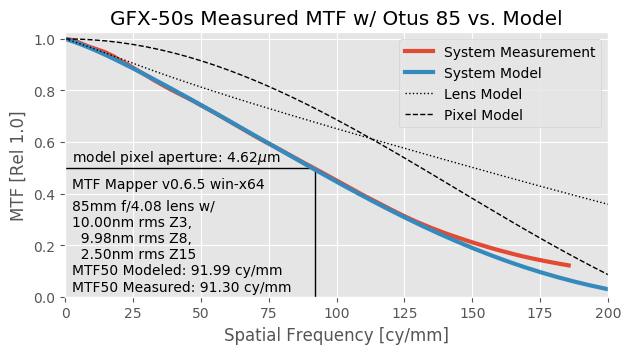

In [15]:
# make a figure
fig, ax = plt.subplots(dpi=100, figsize=(7,3.5))

# plot variosu curves
ax.plot(unit, output_tan, label='System Measurement', lw=3)
ax.plot(u_s, t_s, label='System Model', lw=3)
ax.plot(u_l, t_l, label='Lens Model', ls=':', c='k', lw=1)
ax.plot(u_p, t_p, label='Pixel Model', ls='--', c='k', lw=1)

# draw metadata
ax.text(2.5, 0.42, 'MTF Mapper v0.6.5 win-x64')
ax.text(2.5, 0.38, f'85mm f/{fno:.2f} lens w/\n' +
        f'{defocus:.2f}nm rms Z3,' + '\n' +
        f'  {sa3:.2f}nm rms Z8,' + '\n' +
        f'  {sa5:.2f}nm rms Z15' + '\n' +
        f'MTF50 Modeled: {freq:.2f} cy/mm' + '\n' +
        f'MTF50 Measured: {freq2:.2f} cy/mm', va='top')

# draw retrieved pixel size
ax.text(2.5, 0.525, f'model pixel aperture: {float(pix_size[0]):.2f}$\mu$m')
ax.vlines(freq, ymin=0, ymax=0.5, lw=1)
ax.hlines(0.5, xmin=0, xmax=freq, lw=1)
ax.set(xlabel='Spatial Frequency [cy/mm]',
       ylabel='MTF [Rel 1.0]',
       xlim=(0,200),
       ylim=(0,1.025))
plt.title('GFX-50s Measured MTF w/ Otus 85 vs. Model')
plt.legend(loc='upper right');
plt.savefig('Estimating Effective Pixel Aperture_files/gfx_nonlinear_optimization.png', dpi=200, bbox_inches='tight')

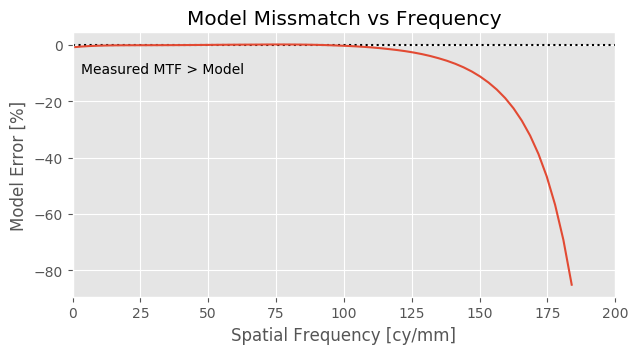

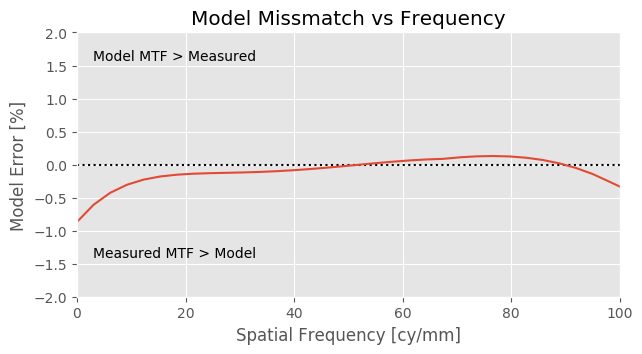

In [16]:
# interpolate the measurement onto the model frequency grid.
# splines are more suited to coming from sparse sampling.
max_idx = np.searchsorted(u_s, unit[-1])
bandlimited_unit = u_s[:max_idx]
bandlimited_model = t_s[:max_idx]
interpf = UnivariateSpline(unit, output_tan, k=5)
interpolated_meas = interpf(bandlimited_unit)

error = bandlimited_model - interpolated_meas
error = error / bandlimited_model * 100

fig, ax = plt.subplots(dpi=100, figsize=(7,3.5))
ax.plot(bandlimited_unit, error)
ax.hlines(0, 0, 200, linestyles=':')
ax.text(3, -10, 'Measured MTF > Model')
ax.set(xlabel='Spatial Frequency [cy/mm]', xlim=(0,200),
       ylabel='Model Error [%]',
       title='Model Missmatch vs Frequency');
#plt.legend
plt.savefig('Estimating Effective Pixel Aperture_files/err_full_range.png', dpi=300, bbox_inches='tight')
fig, ax = plt.subplots(dpi=100, figsize=(7,3.5))
ax.plot(bandlimited_unit, error)
ax.hlines(0, 0, 200, linestyles=':')
ax.text(3, -1.4, 'Measured MTF > Model')
ax.text(3, 1.575, 'Model MTF > Measured')
ax.set(xlabel='Spatial Frequency [cy/mm]', xlim=(0,100),
       ylabel='Model Error [%]', ylim=(-2, 2),
       title='Model Missmatch vs Frequency');
plt.savefig('Estimating Effective Pixel Aperture_files/err_to_nyquist.png', dpi=300, bbox_inches='tight')

There appears to be error at 0 due to the spline fit to the measured data being less than exact.  Linear fitting may be a better technique to match the sample points of these two curves.